### This makes an API request to the "H2NOW" website for the Chicago River Pollution data

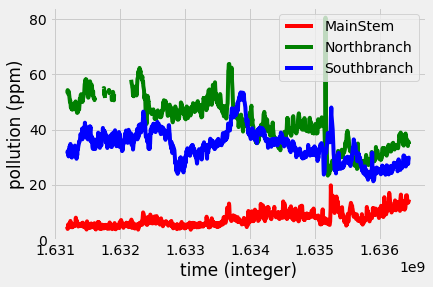

In [5]:
import requests
import matplotlib.pyplot as plt
import matplotlib as mpl
from datetime import datetime
import pandas as pd
import calendar
import seaborn as sns
plt.rcParams["patch.force_edgecolor"]= True
plt.style.use("fivethirtyeight")
mpl.rc("patch", edgecolor = "dimgray", linewidth = 1)


#headers for API response
headers = {
    'authority': 'dvlzjowx88.execute-api.us-west-2.amazonaws.com',
    'sec-ch-ua': '" Not A;Brand";v="99", "Chromium";v="96", "Google Chrome";v="96"',
    'sec-ch-ua-mobile': '?0',
    'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.93 Safari/537.36',
    'sec-ch-ua-platform': '"macOS"',
    'accept': '*/*',
    'origin': 'https://s3.us-east-2.amazonaws.com',
    'sec-fetch-site': 'cross-site',
    'sec-fetch-mode': 'cors',
    'sec-fetch-dest': 'empty',
    'referer': 'https://s3.us-east-2.amazonaws.com/',
    'accept-language': 'en-US,en;q=0.9',
}

#response with all the data
response = requests.get('https://dvlzjowx88.execute-api.us-west-2.amazonaws.com/h2now/all-branches/bacteria/latest', headers=headers)
db = response.json()

#parsing data into the different river branches
Northbranch = db["data"]["dataModel"]["data"][0]["values"]
Southbranch = db["data"]["dataModel"]["data"][1]["values"]
MainStem = db["data"]["dataModel"]["data"][2]["values"]
nbdata = pd.DataFrame(columns = ["datetime", "ppm"])
sbdata = pd.DataFrame(columns = ["datetime", "ppm"])
msdata = pd.DataFrame(columns = ["datetime", "ppm"])


#input strig with datime data
def getDateTime(timesamp):
    year = int(timesamp.split("-")[0])
    month = int(timesamp.split("-")[1])
    day = int(timesamp.split("-")[2].split("T")[0])
    hour = int(timesamp.split("-")[2].split("T")[1].split(":")[0])
    minute = int(timesamp.split("-")[2].split("T")[1].split(":")[1])
    second = int(timesamp.split("-")[2].split("T")[1].split(":")[2].split(".")[0])    
    return datetime(year, month, day, hour, minute, second)

#gets the datetime stamp for each datapoint 
for i in range(len(Northbranch)):
    nbdata = nbdata.append({"datetime": getDateTime(Northbranch[i]["timeOfSample"]) , "ppm": Northbranch[i]["value"]}, ignore_index=True)
    
for k in range(len(Southbranch)):
    sbdata = sbdata.append({"datetime": getDateTime(Southbranch[k]["timeOfSample"]) , "ppm": Southbranch[k]["value"]}, ignore_index=True)
    
    
for k in range(len(MainStem)):
     msdata = msdata.append({"datetime": getDateTime(MainStem[k]["timeOfSample"]), "ppm": MainStem[k]["value"]}, ignore_index= True)
        
#mainstem data
y = list(msdata["ppm"])
x = list(msdata["datetime"])
x = [calendar.timegm(i.timetuple()) for i in x]

#northbranch data
r = list(nbdata["ppm"])
s = list(nbdata["datetime"])
s = [calendar.timegm(i.timetuple()) for i in s]

#southbranch data
t = list(sbdata["ppm"])
u = list(sbdata["datetime"])
u = [calendar.timegm(i.timetuple()) for i in u]

#ploting the data
plot = plt.plot(x,y, "red")
plot = plt.plot(s,r, "green")
plot = plt.plot(u,t, "blue")
plt.xlabel("time (integer)")
plt.ylabel("pollution (ppm)")
plt.legend(["MainStem", "Northbranch", "Southbranch"], loc ="upper right")
plt.show()
   

### This Section Uses Machine Learning to predict the future pollution of the river 

In [9]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils import np_utils

# fix random seed for reproducibility
#np.random.seed(7)
thedata = list(nbdata["ppm"])


# prepare the dataset of input to output as sequence input to float output
seq_length = 4
dataX = []
dataY = []
for i in range(0, len(thedata) - seq_length, 1):
    seq_in = thedata[i:i + seq_length]
    seq_out = thedata[i + seq_length]
    dataX.append([seq_in])
    dataY.append([seq_out])
    
#splits the data into parts for training and parts for testing
percenttrain = 0.75 #the fractional amount of data that will be used for training

trainXp = dataX[0:int(0.75*len(dataX))]
testXp = dataX[int(0.75*len(dataX)): (len(dataX))]
   
trainYp = dataY[0:int(0.75*len(dataY))]
testYp = dataY[int(0.75*len(dataY)): (len(dataY))]
    
trainX = []
trainY = []

#remove NAN from the training data
for i in range(len(trainXp)):
    if True in np.isnan(trainXp[i]) or True in np.isnan(trainYp[i]):
        pass
    else:
        trainX.append(trainXp[i])
        trainY.append(trainYp[i])

#trainX = np.array(trainX)
#trainY = np.array(trainY)

#remove NAN from the testing data
testX = []
testY  = []
for i in range(len(testXp)):
    if True in np.isnan(testXp[i]) or True in np.isnan(testYp[i]):
        pass
    else:
        testX.append(testXp[i])
        testY.append(testYp[i])
        
#converts them to numpy arrays
#testX = np.array(testX)
#testY = np.array(testY)

#this from other code but appears identical to the other reshape one        
#trainX = np.reshape(trainX, (trainX.shape[0],1, trainX.shape[1]))



# reshape X to be [samples, time steps, features]
X = np.reshape(trainX, (len(trainX), 1, seq_length))
# not normalizing right now
#X = X / float(len(alphabet))

# one hot encode the output variable (we are not doing this ase we have numerical rather than categorical data)
#y = np_utils.to_categorical(dataY)
y = np.array(trainY)

#create and fit the model
model = Sequential()
model.add(LSTM(32, input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(y.shape[1], activation='relu'))
model.compile(loss = "mean_squared_error", optimizer = "adam")
model.fit(X, y, epochs=210, batch_size=1, verbose=2)


# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.fit(X, y, epochs=500, batch_size=1, verbose=2)
#weave in this model 
# model = Sequential()
# model.add(LSTM(4, input_shape = (1, 1)))
# model.add(Dense(1))
# model.compile(loss = "mean_squared_error", optimizer = "adam") 
# model.fit(trainX, trainY, epochs = 500, batch_size = 32, verbose = 2)
# # summarize performance of the model
# scores = model.evaluate(X, y, verbose=0)
# print("Model Accuracy: %.2f%%" % (scores[1]*100))
# # demonstrate some model predictions
# for pattern in dataX:
#     x = numpy.reshape(pattern, (1, 1, len(pattern)))
#     x = x / float(len(alphabet))
#     prediction = model.predict(x, verbose=0)
#     index = numpy.argmax(prediction)
#     result = int_to_char[index]
#     seq_in = [int_to_char[value] for value in pattern]
#     print(seq_in, "->", result)
    
    
    

    
    
    

Epoch 1/210
640/640 - 3s - loss: 1383.1354 - 3s/epoch - 5ms/step
Epoch 2/210
640/640 - 1s - loss: 658.4015 - 1s/epoch - 2ms/step
Epoch 3/210
640/640 - 1s - loss: 301.0042 - 1s/epoch - 2ms/step
Epoch 4/210
640/640 - 1s - loss: 129.3318 - 1s/epoch - 2ms/step
Epoch 5/210
640/640 - 1s - loss: 63.2651 - 1s/epoch - 2ms/step
Epoch 6/210
640/640 - 1s - loss: 44.0310 - 1s/epoch - 2ms/step
Epoch 7/210
640/640 - 1s - loss: 37.9318 - 1s/epoch - 2ms/step
Epoch 8/210
640/640 - 1s - loss: 35.2103 - 1s/epoch - 2ms/step
Epoch 9/210
640/640 - 1s - loss: 31.7915 - 1s/epoch - 2ms/step
Epoch 10/210
640/640 - 1s - loss: 30.8470 - 1s/epoch - 2ms/step
Epoch 11/210
640/640 - 2s - loss: 30.3315 - 2s/epoch - 2ms/step
Epoch 12/210
640/640 - 1s - loss: 28.6988 - 1s/epoch - 2ms/step
Epoch 13/210
640/640 - 1s - loss: 26.4090 - 1s/epoch - 2ms/step
Epoch 14/210
640/640 - 1s - loss: 26.0907 - 1s/epoch - 2ms/step
Epoch 15/210
640/640 - 2s - loss: 24.4906 - 2s/epoch - 3ms/step
Epoch 16/210
640/640 - 2s - loss: 23.7752 - 

Epoch 130/210
640/640 - 1s - loss: 9.6368 - 1s/epoch - 2ms/step
Epoch 131/210
640/640 - 1s - loss: 9.2155 - 1s/epoch - 2ms/step
Epoch 132/210
640/640 - 1s - loss: 9.2372 - 1s/epoch - 2ms/step
Epoch 133/210
640/640 - 1s - loss: 9.1170 - 1s/epoch - 2ms/step
Epoch 134/210
640/640 - 1s - loss: 8.8166 - 1s/epoch - 2ms/step
Epoch 135/210
640/640 - 1s - loss: 9.9822 - 1s/epoch - 2ms/step
Epoch 136/210
640/640 - 1s - loss: 9.1784 - 1s/epoch - 2ms/step
Epoch 137/210
640/640 - 1s - loss: 9.6661 - 1s/epoch - 2ms/step
Epoch 138/210
640/640 - 1s - loss: 8.8695 - 1s/epoch - 2ms/step
Epoch 139/210
640/640 - 1s - loss: 8.7818 - 1s/epoch - 2ms/step
Epoch 140/210
640/640 - 1s - loss: 9.5083 - 1s/epoch - 2ms/step
Epoch 141/210
640/640 - 1s - loss: 9.3073 - 1s/epoch - 2ms/step
Epoch 142/210
640/640 - 1s - loss: 9.5461 - 1s/epoch - 2ms/step
Epoch 143/210
640/640 - 1s - loss: 8.5658 - 1s/epoch - 2ms/step
Epoch 144/210
640/640 - 2s - loss: 8.7341 - 2s/epoch - 3ms/step
Epoch 145/210
640/640 - 2s - loss: 8.668

In [10]:
from sklearn.metrics import mean_squared_error
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainScore = np.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
testScore = np.sqrt(mean_squared_error(testY, testPredict[:,0]))

print("trainscore:" , trainScore)
print("testscore:" , testScore)



trainscore: 2.4423498922274387
testscore: 1.3171383954547127


# This graph shows how well the model predicted future water pollution levels

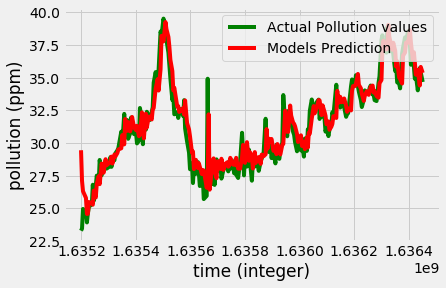

In [11]:

#get last 233 entries from the time series
k=s[-233:]

plot = plt.plot(k,testY, "green")
plot = plt.plot(k,testPredict, "red")
plt.xlabel("time (integer)")
plt.ylabel("pollution (ppm)")
plt.legend(["Actual Pollution values", "Models Prediction"], loc ="upper right")
plt.show()

### At 210 Epochs the model does a good job of predicting the pollution levels.
